<a href="https://colab.research.google.com/github/kbpavan/SalaryPredictions/blob/master/Project__.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connecting to datasets in Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Importing packages**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
import xgboost as xgb
from tqdm import tqdm


Using TensorFlow backend.


# DISCOVER Data

In [0]:
link = '/content/drive/My Drive/Colab Notebooks/train_features.csv'
link2 = '/content/drive/My Drive/Colab Notebooks/train_salaries.csv'
link3 = '/content/drive/My Drive/Colab Notebooks/test_features.csv'
train_features = pd.read_csv(link)
train_salaries = pd.read_csv(link2)



**Target salaries DataFrame**

In [4]:
train_salaries.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


**Features DataFrame**

In [5]:
train_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


**Merging 2 data frames**

In [0]:
merged_data = pd.merge(train_features,train_salaries,how='inner', on='jobId')

**Ckecking for any duplicate data**

In [7]:

len(merged_data[merged_data.duplicated()])


0

**Removing jobid coulmn as it is unique for each row**


In [0]:
merged_data = merged_data.drop('jobId', axis = 1)


**Examine potential outliers**

**Checking for any odd values in numeric data**

In [9]:
merged_data.describe()

,yearsExperience,milesFromMetropolis,salary
count,1000000.000000,1000000.000000,1000000.000000
mean,11.992386,49.529260,116.061818
std,7.212391,28.877733,38.717936
min,0.000000,0.000000,0.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


**Looks like salary column is having some salaries as 0. This is odd, have to look deeply into the reasons.**

In [10]:
Salary_Zero =  merged_data[merged_data.salary== 0]
Salary_Zero

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


**These are the only 5 rows that are having salaries as 0. Looking at their degrees and jobtypes, we can remove this data as bad data.**

In [0]:
merged_data = merged_data[merged_data.salary != 0]

**Visualizing target variable**

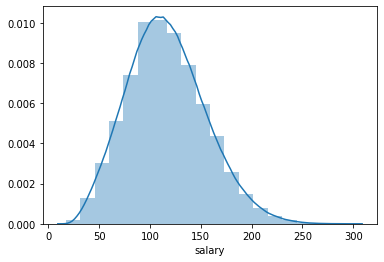

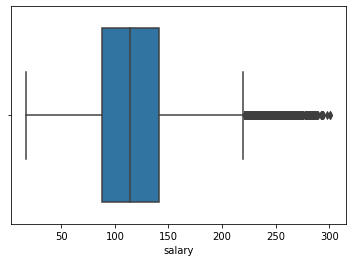

In [12]:
sns.distplot(merged_data.salary, bins=20)
plt.show()
sns.boxplot(merged_data.salary)
plt.show()

**From the box plot it looks like there are some outliers in salaries.**

**Removing outliers using upper/lower limts from Inter Quartile range calculation**

In [13]:
results = merged_data.salary.describe()
InterQuartileRange = results['75%'] - results['25%']
Upperlimit = results['75%'] +( 1.5 * InterQuartileRange )
lowerlimit = results['25%'] - ( 1.5 * InterQuartileRange )
print("Upperlimit:",Upperlimit,"lowerlimit:", lowerlimit)


Upperlimit: 220.5 lowerlimit: 8.5


**We will look at the jobs of people having salaries greater than 220.5**

In [14]:
merged_data[merged_data.salary > 220.5]['jobType'].value_counts()

CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
Name: jobType, dtype: int64

**Most of the people are in C-Suite as expected but there are some Junior positions having salaries >220k. We will see which industries have junior positions with 220k + salaries**

In [15]:
merged_data[(merged_data.salary > 220.5) & (merged_data.jobType == 'JUNIOR')].industry.value_counts()

OIL        11
FINANCE     8
WEB         1
Name: industry, dtype: int64

**Oil and finance industries are known for higher salaries so this data looks legitimate.**

**Now we will look at People having less than 8k salaries**

In [16]:
merged_data[merged_data.salary < 8.5].jobType.value_counts()

Series([], Name: jobType, dtype: int64)

**These doesn't look true. So we remove these records from data**

In [0]:
merged_data = merged_data[merged_data.salary > 8.5]


**Now we will look at Categorical data**

In [18]:
merged_data.describe(include = ['O'])

,companyId,jobType,degree,major,industry
count,999995,999995,999995,999995,999995
unique,63,8,5,9,7
top,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,16193,125886,236975,532353,143205


**We will look at jobs with people having no degrees**

In [19]:
merged_data[merged_data.degree == 'NONE'].jobType.value_counts()

JANITOR           62544
SENIOR            25117
MANAGER           25092
CEO               24898
CTO               24882
VICE_PRESIDENT    24825
JUNIOR            24781
CFO               24714
Name: jobType, dtype: int64

**It is strange that C-level positions having Degree as None. We can't assume them as not having degree or we can't remove records having major as none because >50% values are missing. Let us leave it as None and continue our analysis.**



*   **A function to automate building several plots**
*   **If the predictor is a numeric type, distribution and correlation of predictor with target variable(salaries) is plotted**
*   **If the predictor is categorical type, box plots of salaries over different levels of that categorical and their frequency counts are plotted**

In [0]:
def  plots(df, column):
    if df[column].dtype.name == 'int64':
        sns.jointplot(column,'salary', data = df, kind= 'reg',joint_kws = {'scatter_kws':dict(alpha=0.2)} ).annotate(stats.pearsonr)
        plt.show()
    else:
        
        plt.figure(figsize=(7, 6))
        sns.boxplot(column, 'salary', data = df)
        plt.show()
        
        plt.figure(figsize=(7, 6))
        value_counts = df[column].value_counts()
        no = np.arange(len(value_counts))
        plt.bar( no, value_counts)
        plt.xlabel(column, fontsize=10)
        plt.ylabel('value_counts', fontsize=10)
        plt.xticks(no, value_counts.index , fontsize=10, rotation=30)
        plt.title('Frequency')
        plt.show()

**Calling the function on different variables**

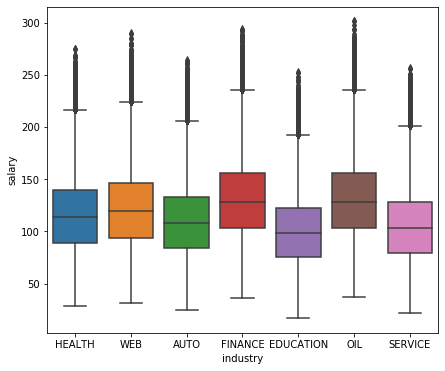

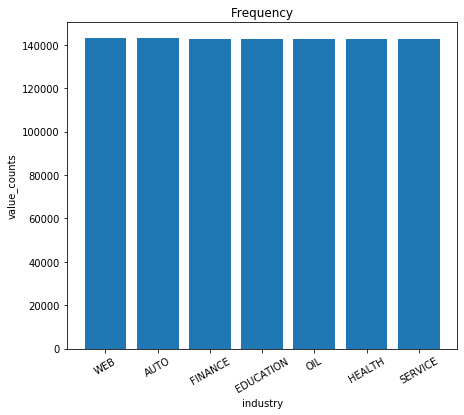

In [21]:

plots(merged_data,'industry')

**From the above plot we can see that OIL and Finance Industries are having highest salaries**

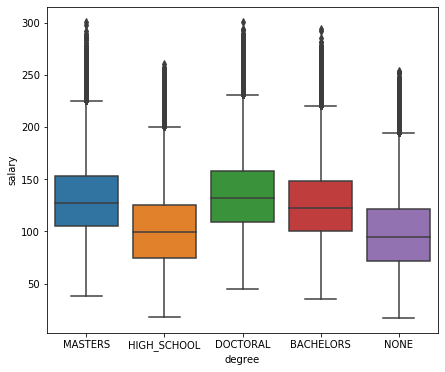

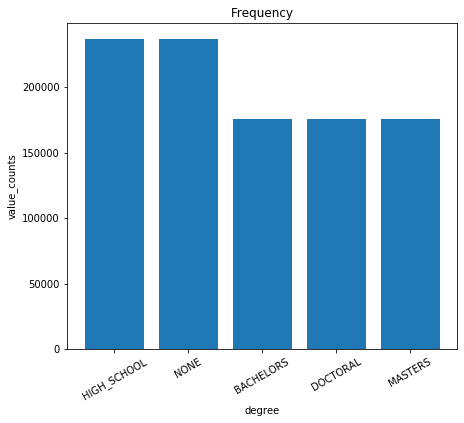

In [22]:
plots(merged_data,'degree')

**From the above plot we can see that DOCTORAL degrees are having highest salaries and surprisingly not much difference in salaries for Bachelors and masters.There are more people with High school degree.**

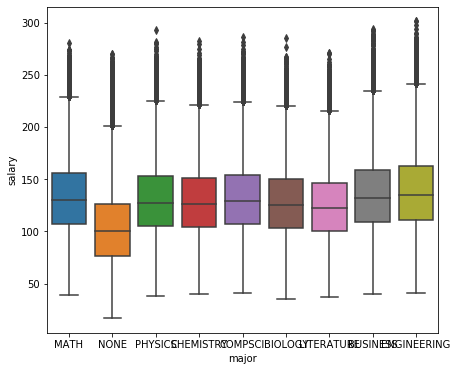

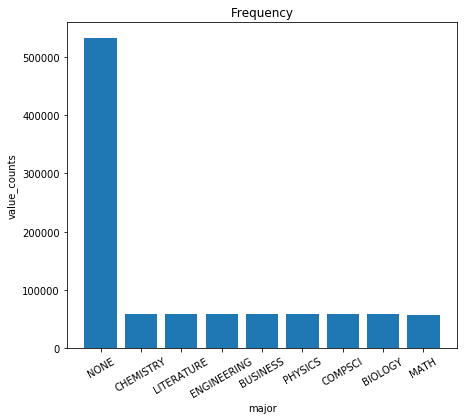

In [23]:
plots(merged_data,'major')

**Engineering and Business majors are having highest salaries**

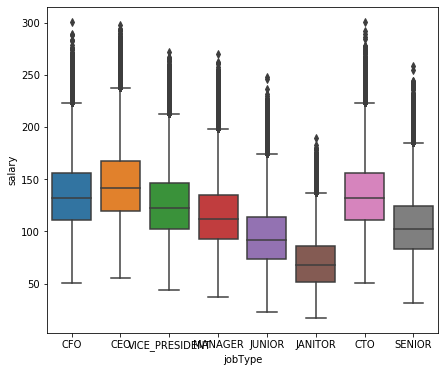

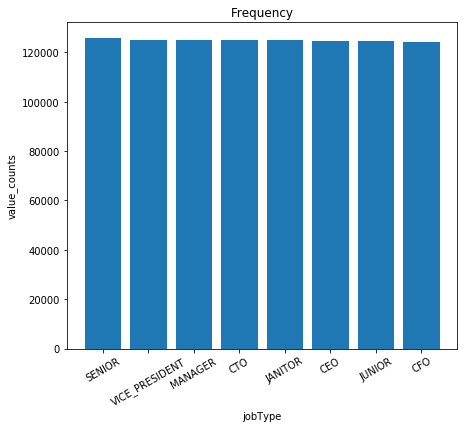

In [24]:

plots(merged_data,'jobType')

**As expected C levels are having highest salaries**

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


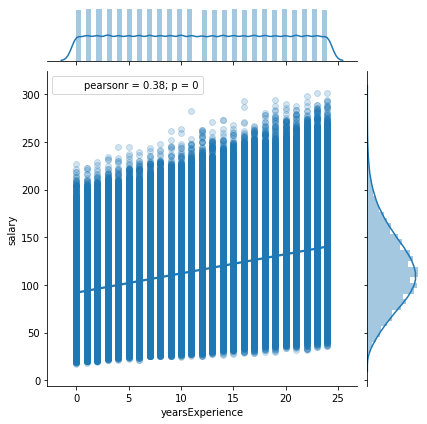

In [25]:
plots(merged_data,'yearsExperience')

**It looks like salaries of people increases with years of experience but also there is wide range for each experience level**

**There are also some people with 0 experience earning very high salaries. There is 0.38 pearson correlation between salary and Years experience**

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


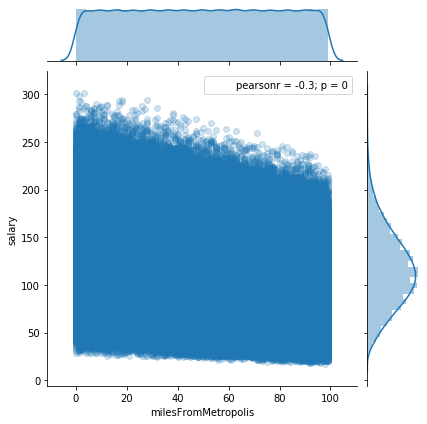

In [26]:
plots(merged_data,'milesFromMetropolis')

**There is a negative correlation of -0.3. we can see from the above figure that, as miles from metropolis area increases , salary decreases. But there is also a wide range for every level.**

**We have to Encode Categorical data for some of our models to work**

**Ordinal encoding for ordinal data**

In [0]:
OE  = OrdinalEncoder(categories= [['JANITOR','JUNIOR','SENIOR','MANAGER','VICE_PRESIDENT','CFO','CTO','CEO']])
merged_data['jobType'] = OE.fit_transform(merged_data[['jobType']])

OE2  = OrdinalEncoder(categories= [["HIGH_SCHOOL", "NONE", "BACHELORS", "MASTERS","DOCTORAL"]])
merged_data['degree'] = OE2.fit_transform(merged_data[['degree']])





**Lable encoding for nominal data**

In [0]:
def LableEncode(columns,df):
    le = LabelEncoder()
    for col in columns:
        df[col] = le.fit_transform(df[col])
columns = ['companyId','major','industry']

LableEncode(columns,merged_data)



In [29]:
merged_data.head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,31,5.0,3.0,6,3,10,83,130
1,11,7.0,0.0,7,6,3,73,101
2,48,4.0,4.0,8,3,10,38,137
3,32,3.0,4.0,2,0,8,17,142
4,60,4.0,2.0,8,2,8,16,163


# Feature Engineering

**I want to create a function to create group statistics variables for our data to gain more signal from data.
We groupby our data for all categorical variables and get salary statistics for that group as new variables**

In [0]:
#Columns to consider for groupby
col = ['companyId', 'jobType', 'degree', 'major', 'industry']

#Function to create group statistics dataframe 
def group_statistics(df, col, target = 'salary'):
     groups = df.groupby(col)
     group_stats = pd.DataFrame({'group_mean': groups[target].mean()})
     group_stats['group_max'] = groups[target].max()
     group_stats['group_min'] = groups[target].min()
     group_stats['group_median'] = groups[target].median()
     group_stats.reset_index(inplace=True)
     return group_stats
group_stats = group_statistics(merged_data,col,'salary') 

**Merge 2 data frames by using left join and joining on categorical columns**

In [31]:
merged_data = pd.merge(merged_data, group_stats, on = col, how='left')
merged_data.head()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,group_mean,group_max,group_min,group_median
0,31,5.0,3.0,6,3,10,83,130,130.875000,150,98,136.0
1,11,7.0,0.0,7,6,3,73,101,138.031250,204,90,132.0
2,48,4.0,4.0,8,3,10,38,137,142.000000,173,116,137.0
3,32,3.0,4.0,2,0,8,17,142,129.000000,169,77,131.0
4,60,4.0,2.0,8,2,8,16,163,153.583333,232,94,141.5


# Model Building

**Now our data is ready for predicition!!**

**Separating data into target and features.**

In [0]:
# Splitting the dataset into predictors(x) and target(y)
x = merged_data.drop('salary', axis = 1)
y = merged_data['salary']


**Splitting the dataset into Test and train sets**

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)


**The 5 models selected to test metrics are,**


1.   Linear Regression without scaling and PCA
2.   Linear Regression with scaling and PCA
3.   Random Forest Regressor
4.   XGBoost 
5.   Neural network



In [0]:
class ModelBuilder:
    def __init__(self, models=[]):#, default_num_iters=10, verbose_lvl=0):
        '''initializes model list and dicts'''
        self.models = models
        self.best_model = None
        self.predictions = None
        self.mean_mse = {}
        self.Test_MSE = {}
        
    def add_model(self, model):
        self.models.append(model)

    def cross_validate(self, feature_df,target_df, k, scoringtype):
        '''cross validate models using given data'''
        for model in self.models:
            neg_mse = cross_val_score(model, feature_df, target_df, cv=k, n_jobs=-1, scoring= scoringtype)
            self.mean_mse[model] = -1.0*np.mean(neg_mse)
    
    def TestSet_Results(self, X_train, X_test, y_train, y_test ):
         for model in self.models:
             model.fit(X_train,y_train)
             Test_pred = model.predict(X_test)
             self.Test_MSE[model] = mean_squared_error(y_test,Test_pred)

    def select_best_model(self):
        '''select model with lowest mse'''
        self.best_model = min(self.Test_MSE , key=self.Test_MSE.get)      
        
    def save_results(self):
        pass
    
    @staticmethod
    def get_feature_importance(model, col_Names):
        '''retrieves and sorts feature importances'''
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            feature_importances = pd.DataFrame({'feature':col_Names, 'importance':importances})
            feature_importances.sort_values(by='importance', ascending=False, inplace=True)
            #set index to 'feature'
            feature_importances.set_index('feature', inplace=True, drop=True)
            return feature_importances
        else:
            #some models don't have feature_importances_
            return "Feature importances do not exist for given model"

    def print_summary(self):

        '''prints summary of models, best model, and feature importance'''

        print('\nModel Summaries:\n')

        for model in models.mean_mse:
            print('\n', model, 'TrainSetCV- MSE:', models.mean_mse[model])
            print('\n', model, 'TestSet- MSE:', models.Test_MSE[model])

        print('\nBest Model:\n', models.best_model)
        print('\nMSE of Best Model\n', models.Test_MSE[models.best_model])

        print('\nFeature Importances\n', models.get_feature_importance(models.best_model, col_Names))

        feature_importances = self.get_feature_importance(models.best_model, col_Names)
        feature_importances.plot.bar()
        plt.show()

In [0]:
# ModelBuilder.print_summary()

**Instantiate class and add models to the models list in models object**


**Hyperparameter tuning already done by hand for RandomForest, XGBoost, Neural network models and the models with their best parameters are loaded below(Please find the tuning of models part at the end of notebook)**

In [0]:
#create model container
models = ModelBuilder()

#create models -- hyperparameter tuning already done by hand for each model
models.add_model(LinearRegression())
models.add_model(make_pipeline(StandardScaler(), PCA(), LinearRegression()))
models.add_model(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False))
models.add_model(xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=1,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.9, verbosity=1))

col_Names = ['companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis', 'group_mean', 'group_max',
       'group_min', 'group_median']

**Run methods to get Train Cross validation MSE and Test MSE for all Models**

In [36]:
models.cross_validate(feature_df = X_train, target_df = y_train , k=2, scoringtype = 'neg_mean_squared_error')
models.TestSet_Results(X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test )
models.select_best_model()


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:11:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


**Summarize results**


Model Summaries:


 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) TrainSetCV- MSE: 356.44743455410855

 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) TestSet- MSE: 356.110964265016

 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False) TrainSetCV- MSE: 356.44743455410855

 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(c

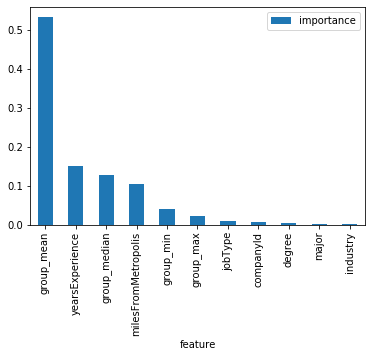

In [37]:
models.print_summary()

**Now we will compare Random Forest MSE with Neural Networks MSE and see which has lowest MSE!**

# Neural Networks


 **Scaling predictors using Standard scalar**

In [0]:

Predictors = (X_train).values
target = (y_train).values.reshape(-1, 1)

from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_test_x = StandardScaler()
Predictors = sc_X.fit_transform(Predictors)
X_test_scaled = sc_test_x.fit_transform((X_test).values)
y_test = y_test.values.reshape(-1, 1)


**Building Neural network model**

In [0]:
early_stopping_monitor = EarlyStopping(patience=3)
n_cols = Predictors.shape[1]
model = Sequential()
model.add(Dense(200,activation='relu',input_shape = (n_cols,)))
model.add(Dense(200,activation='relu'))
model.add(Dense(200,activation='relu'))
model.add(Dense(200,activation='relu'))
model.add(Dense(200,activation='relu'))
model.add(Dense(200,activation='relu'))
model.add(Dense(200,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(Predictors,target,validation_split = 0.3, epochs = 30, callbacks = [early_stopping_monitor])









Train on 524997 samples, validate on 224999 samples
Epoch 1/30





524997/524997 [==============================] - 88s 167us/step - loss: 359.9865 - val_loss: 335.0844
Epoch 2/30
524997/524997 [==============================] - 77s 146us/step - loss: 325.3053 - val_loss: 316.0515
Epoch 3/30
524997/524997 [==============================] - 78s 149us/step - loss: 321.2477 - val_loss: 311.0117
Epoch 4/30
524997/524997 [==============================] - 77s 147us/step - loss: 318.7533 - val_loss: 312.6847
Epoch 5/30
524997/524997 [==============================] - 76s 145us/step - loss: 317.1576 - val_loss: 310.5636
Epoch 6/30
524997/524997 [==============================] - 76s 145us/step - loss: 315.6955 - val_loss: 311.3954
Epoch 7/30
524997/524997 [==============================] - 77s 147us/step - loss: 314.8352 - val_loss: 308.0541
Epoch 8/30
524997/524997 [==============================] - 76s 145us/step - loss: 313.5576 - val_loss: 308.4486
Epoch 9/30
524997/524997 [======

In [0]:
predictions = model.predict(X_test_scaled)

MSE_Neural_network = mean_squared_error(y_test,predictions)
print('MSE_Neural_network',MSE_Neural_network)

MSE_Neural_network 312.0905771702329


# Random Forest Model Tuning

 

*  **Here we will first hand tune the model by changing one Hyperparameter value at a time and and keeping all others parameters constant**
*   **Then we will perform grid search for fine tuning the hyperparameters by using hyperparameter values in the neighbourhood of hand tuned parameters**


**Baseline model without any tuning of hyperparameter space**

In [0]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0,n_jobs = -1)
regressor.fit(X_train,y_train)

X_test = np.array(X_test)

# Predicting a new result
y_pred = regressor.predict(X_test)

#MSE
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,y_pred)


339.0356263400887

**Hand tuning model for better hyper parameters**

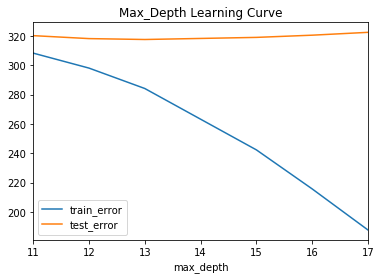

In [0]:
#Hyper paarmeter tuning
#Manually search for best max_depth
# Create empty array to store results
results = []
# Enumerate through different max_depth values and store results
for max_depth in [11,12,13,15,16,17]:
    RF = RandomForestRegressor(max_depth = max_depth,n_jobs = -1)
    RF.fit(X_train,y_train)
    results.append(
        {
            'max_depth': max_depth,
            'train_error': metrics.mean_squared_error(y_train, RF.predict(X_train)),
            'test_error': metrics.mean_squared_error(y_test, RF.predict(X_test))
        })

# Display Results
max_depth_lr = pd.DataFrame(results).set_index('max_depth').sort_index()
max_depth_lr

# Plot Max_Depth Learning Curve
max_depth_lr.plot(title="Max_Depth Learning Curve")

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

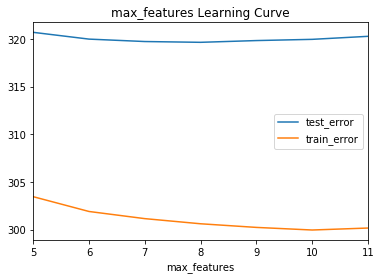

In [0]:
#Manually search for best max_features
results = []
for max_features in [5,6,7,8,9,10,11]:
    RF = RandomForestRegressor(max_features = max_features, max_depth  =12,n_jobs = -1)
    RF.fit(X_train,y_train)
    results.append(
        {
            'max_features': max_features,
            'train_error': metrics.mean_squared_error(y_train, RF.predict(X_train)),
            'test_error': metrics.mean_squared_error(y_test, RF.predict(X_test))
        })

max_features_df = pd.DataFrame(results).set_index('max_features').sort_index()
max_features_df
max_features_df.plot(title="max_features Learning Curve")

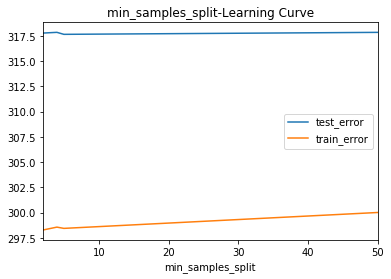

In [0]:

#For Best min_samples_split Parameter

results = []
for min_samples_split in [2,4,5,50]:
    RF = RandomForestRegressor(min_samples_split = min_samples_split, n_estimators = 40, max_depth  =12,max_features = 9,n_jobs = -1 )
    RF.fit(X_train,y_train)
    results.append(
        {
            'min_samples_split': min_samples_split,
            'train_error': metrics.mean_squared_error(y_train, RF.predict(X_train)),
            'test_error': metrics.mean_squared_error(y_test, RF.predict(X_test))
        })

min_samples_split_df = pd.DataFrame(results).set_index('min_samples_split').sort_index()
min_samples_split_df
min_samples_split_df.plot(title="min_samples_split-Learning Curve")

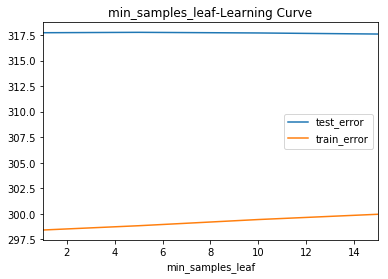

In [0]:
#For Best min_samples_leaf Parameter

results = []
for min_samples_leaf in [1,5,10,15]:
    RF = RandomForestRegressor(min_samples_leaf = min_samples_leaf,n_estimators = 40, max_depth  =12,max_features = 9,min_samples_split=3,n_jobs = -1 )
    RF.fit(X_train,y_train)
    results.append(
        {
            'min_samples_leaf': min_samples_leaf,
            'train_error': metrics.mean_squared_error(y_train, RF.predict(X_train)),
            'test_error': metrics.mean_squared_error(y_test, RF.predict(X_test))
        })

min_samples_leaf_df = pd.DataFrame(results).set_index('min_samples_leaf').sort_index()
min_samples_leaf_df
min_samples_leaf_df.plot(title="min_samples_leaf-Learning Curve")

Using the results obtained from individual tuning now we will implement Grid search to get even better hyper parameters for Random forest


In [0]:
#Performing GridSearchCV
from sklearn.model_selection import GridSearchCV
model = RandomForestRegressor(n_jobs = -1)
# Define Parameters
param_grid = {"max_depth": [11,12,13],
              "max_features": [8,9,10],
              "min_samples_split": [3,5],
              "min_samples_leaf":[4,5]
              }
gs_cv = GridSearchCV(model, param_grid=param_grid, cv = 4, n_jobs=-1 ).fit(X_train, y_train)

gs_cv.best_params_ 


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'max_depth': 13,
 'max_features': 8,
 'min_samples_leaf': 5,
 'min_samples_split': 3}

In [0]:
best_model = gs_cv.best_estimator_ 
best_model


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

# XGBoost Model Tuning

** Base model without tuning**

In [0]:

XGBoost = xgb.XGBRegressor()
XGBoost.fit(X_train, y_train)
predictions = XGBoost.predict(X_test)
XGBoost.get_params()
MSE_Neural_network = mean_squared_error(y_test,predictions)
print('MSE_Neural_network',MSE_Neural_network)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:42:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE_Neural_network 367.6388870568415


**Random search of parameters, using 3 fold cross validation, 
searching across 50 different combinations, and using all available cores**

In [0]:

# gamma parameter
gamma = [0,1,5]
# max depth of the tree
max_depth = [3,5,10,15,20]
# no of variables that are being used in tree
colsample_bytree = [0.3,0.5,0.8]
# Minimum number of samples required at each leaf node
subsample = [0.8,0.9,1]
# learning rate for gradient descent
learning_rate = [0.01,0.03,0.05,0.1]
# Create the random grid
random_grid = {'gamma': gamma,
               'max_depth': max_depth,
               'colsample_bytree': colsample_bytree,
               'subsample': subsample,
               'learning_rate': learning_rate}

rf_random = RandomizedSearchCV(estimator = XGBoost, param_distributions = random_grid, n_iter = 50, cv = 3,random_state=42, n_jobs = -1)
best_xgboost_model = rf_random.best_estimator_

In [0]:
best_xgboost_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=1,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.9, verbosity=1)

**Basic feature importance chart**

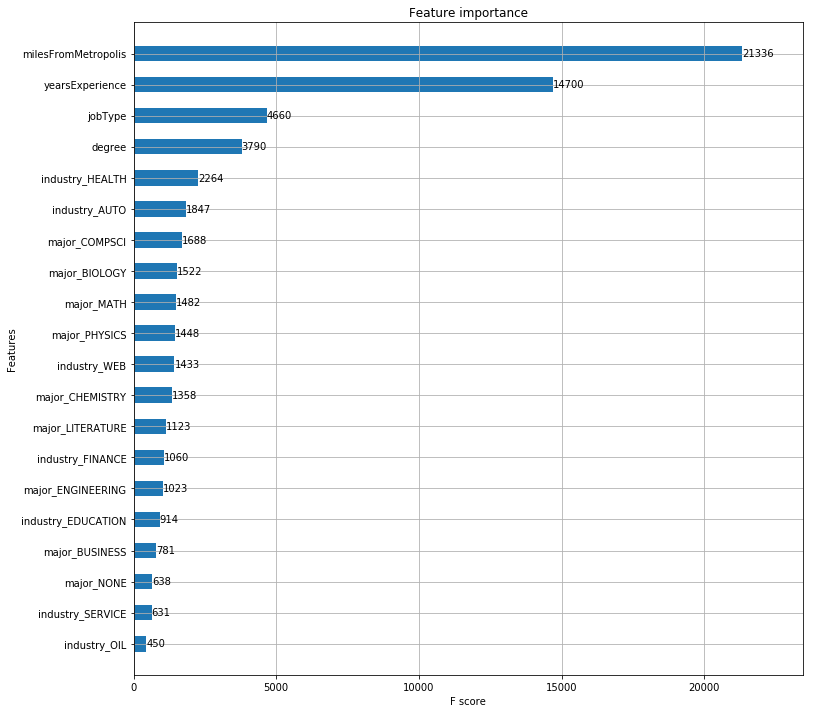

In [0]:
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(best_xgboost_model, height=0.5, ax=ax)
plt.show()